In [25]:
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
df_jan = pd.read_parquet('yellow_tripdata_2022-01.parquet')

In [3]:
df_jan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [4]:
len(df_jan.columns)

19

In [5]:
df_jan['duration'] = df_jan.tpep_dropoff_datetime - df_jan.tpep_pickup_datetime

In [6]:
df_jan.duration = df_jan.duration.apply(lambda td: td.total_seconds() / 60)

In [7]:
df_jan.duration.std()

46.44530513776802

In [8]:
df_jan.shape

(2463931, 20)

/home/michal/miniconda3/envs/mle/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

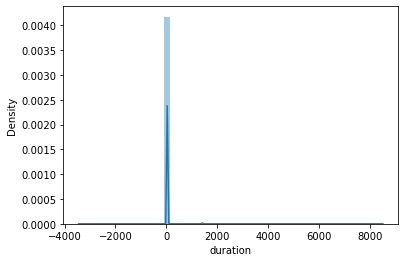

In [9]:
sns.distplot(df_jan.duration)

In [30]:
df_jan_no_outliers = df_jan[(df_jan.duration >= 1) & (df_jan.duration <= 60)]

In [31]:
len(df_jan_no_outliers) / len(df_jan)

0.9827547930522406

In [32]:
features = ['PULocationID', 'DOLocationID']
df_jan_no_outliers[features] = df_jan_no_outliers[features].astype(str)
train_dicts = df_jan_no_outliers[features].to_dict(orient='records')

/tmp/ipykernel_1748/758489196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jan_no_outliers[features] = df_jan_no_outliers[features].astype(str)


In [33]:
train_dicts[0:10]

[{'PULocationID': '142', 'DOLocationID': '236'},
 {'PULocationID': '236', 'DOLocationID': '42'},
 {'PULocationID': '166', 'DOLocationID': '166'},
 {'PULocationID': '114', 'DOLocationID': '68'},
 {'PULocationID': '68', 'DOLocationID': '163'},
 {'PULocationID': '138', 'DOLocationID': '161'},
 {'PULocationID': '233', 'DOLocationID': '87'},
 {'PULocationID': '238', 'DOLocationID': '152'},
 {'PULocationID': '166', 'DOLocationID': '236'},
 {'PULocationID': '236', 'DOLocationID': '141'}]

In [34]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train.shape

(2421440, 515)

In [35]:
target = 'duration'
y_train = df_jan_no_outliers[target]

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [37]:
y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)

6.986190837370544

In [38]:
def prepare_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    features = ['PULocationID', 'DOLocationID']
    df[features] = df[features].astype(str)

    return df

In [39]:
df_feb = prepare_dataframe('yellow_tripdata_2022-02.parquet')

In [40]:
val_dicts = df_feb[features].to_dict(orient='records')

In [41]:
X_val = dv.transform(val_dicts)
y_val = df_feb[target]

In [42]:
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

7.786409085078911